In [1]:
# https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

# Micrograd

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

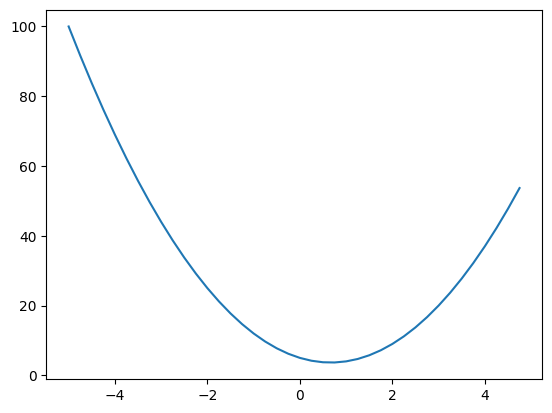

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
# derivative of fucntion for different point on this curve

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [8]:
# deriv for a single point
h = 0.0001

d1 = a * b + c
a += h
d2 = a * b + c
print("d1: ", d1)
print("d2: ", d2)
print("slow wrt a: ", (d2-d1)/h)

d1:  4.0
d2:  3.999699999999999
slow wrt a:  -3.000000000010772


In [9]:
class Value:
    # wraps expression
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data=({self.data}))"

In [10]:
a = Value(2.0)
a

Value(data=(2.0))

In [11]:
class Value:
    # wraps expression
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        # allow adding of two Value obj
        return Value(self.data + other.data)

    def __mul__(self, other):
        # allow multiplying of two Value obj
        return Value(self.data * other.data)

In [12]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a*b+c

Value(data=(4.0))

In [13]:
# create operations graph
class Value:
    # wraps expression
    # children stores what values created this valye
    # op stores what operations on children exactly created this value
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        # allow adding of two Value obj
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        # allow multiplying of two Value obj
        return Value(self.data * other.data, (self, other), '*')

In [14]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b+c
print(d._prev)
print(d._op)

{Value(data=(-6.0)), Value(data=(10.0))}
+


In [15]:
# visualize expression graph
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # create graph left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for values create rectangular node
        dot.node(name=uid, label="{ data %.4f }" % (n.data, ), shape="record")
        if n._op:
            # if current node is result of some operation
            # create op node for it
            dot.node(name=uid+n._op, label=n._op)
            # connect node to op node
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

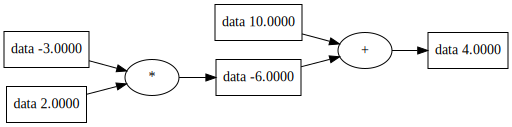

In [16]:
draw_dot(d)

In [17]:
# add label to each value for easy debugging
class Value:
    # wraps expression
    # children stores what values created this valye
    # op stores what operations on children exactly created this value
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        # allow adding of two Value obj
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        # allow multiplying of two Value obj
        return Value(self.data * other.data, (self, other), '*')

In [18]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b+c
d.label = 'd'
print(d._prev)
print(d._op)
print(d.label)

{Value(data=(10.0)), Value(data=(-6.0))}
+
d


In [19]:
# graph with label
# visualize expression graph
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # create graph left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for values create rectangular node
        dot.node(name=uid, label="{ %s | data %.4f }" % (n.label, n.data), shape="record")
        if n._op:
            # if current node is result of some operation
            # create op node for it
            dot.node(name=uid+n._op, label=n._op)
            # connect node to op node
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

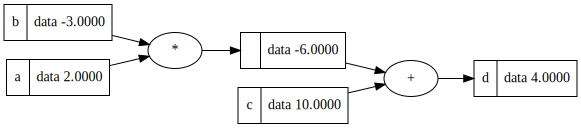

In [20]:
draw_dot(d)

In [21]:
# add grad to each value for its gradient to output
class Value:
    # wraps expression
    # children stores what values created this valye
    # op stores what operations on children exactly created this value
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        # allow adding of two Value obj
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        # allow multiplying of two Value obj
        return Value(self.data * other.data, (self, other), '*')

In [22]:
# graph with grad
# visualize expression graph
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # create graph left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for values create rectangular node
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # if current node is result of some operation
            # create op node for it
            dot.node(name=uid+n._op, label=n._op)
            # connect node to op node
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

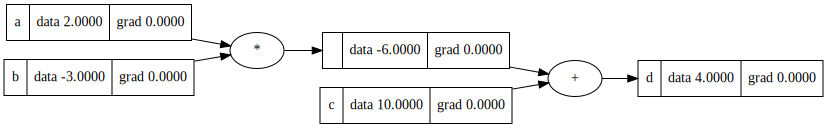

In [23]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b+c
d.label = 'd'
draw_dot(d)

In [24]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=(-8.0))

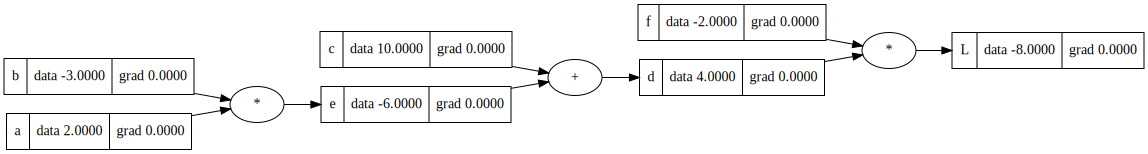

In [25]:
draw_dot(L)

In [26]:
# calc gradient numerically
def lol():
    # deriv of output L wrt to L
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    # b.data += h
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h

    print((L2 - L1)/h)

lol()

1.000000000000334


In [27]:
# found it manually
L.grad = 1

In [28]:
# calc gradient numerically
def lol():
    # deriv of output L wrt to d
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    # b.data += h
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-2.000000000000668


In [29]:
d.grad = -2

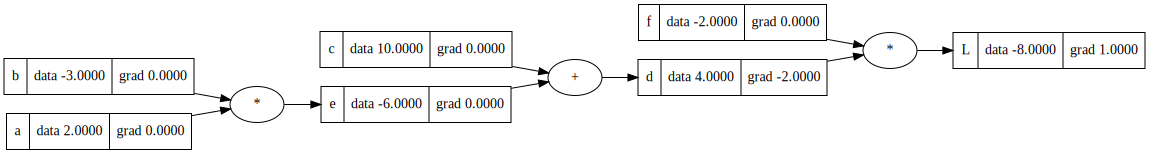

In [30]:
draw_dot(L)

In [31]:
# we use numerical deriv comutation to do graident checking
# after getting backprop grads
# use chain rule to get dL/dc = dL/dd * dd/dc

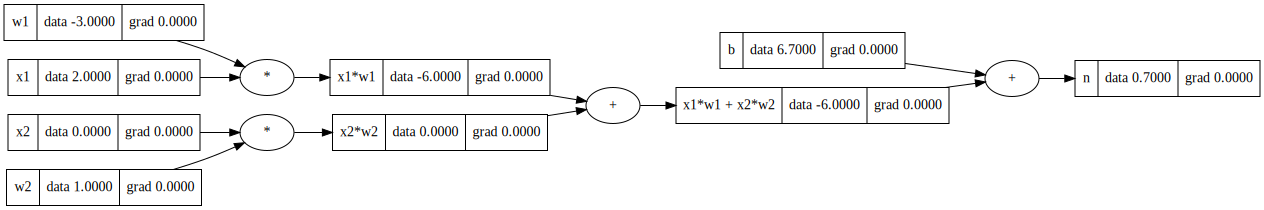

In [32]:
# manual backprop for neuron
# x1, x2 inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
draw_dot(n)

In [33]:
# add tanh implementation for neural netwoek activation function
class Value:
    # wraps expression
    # children stores what values created this valye
    # op stores what operations on children exactly created this value
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        # allow adding of two Value obj
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        # allow multiplying of two Value obj
        return Value(self.data * other.data, (self, other), '*')

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        return out

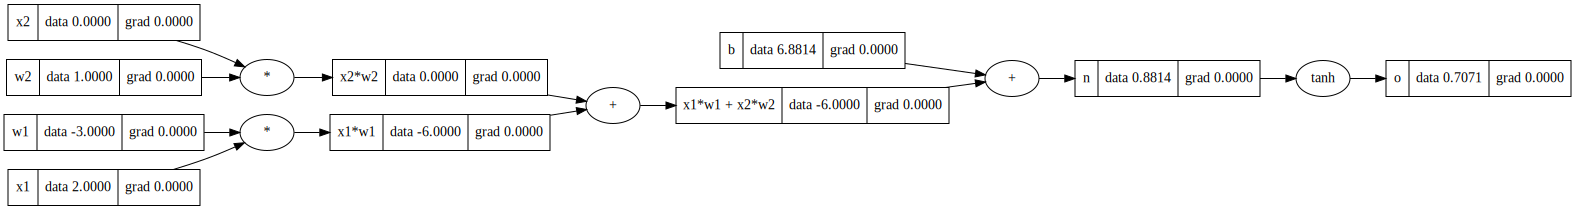

In [34]:
# manual backprop for neuron
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [35]:
o.grad = 1.0 # do/do

In [36]:
# do/dn
# o = tanh(n)
# do/dn = 1-tanh(n)**2 = 1-o**2
1-o.data**2

0.4999999999999999

In [37]:
n.grad = 0.5

In [38]:
# summation distrubutes grad equally to operands
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [39]:
# summation distrubutes grad equally to operands
x1w1.grad = 0.5
x2w2.grad = 0.5

In [40]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [41]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

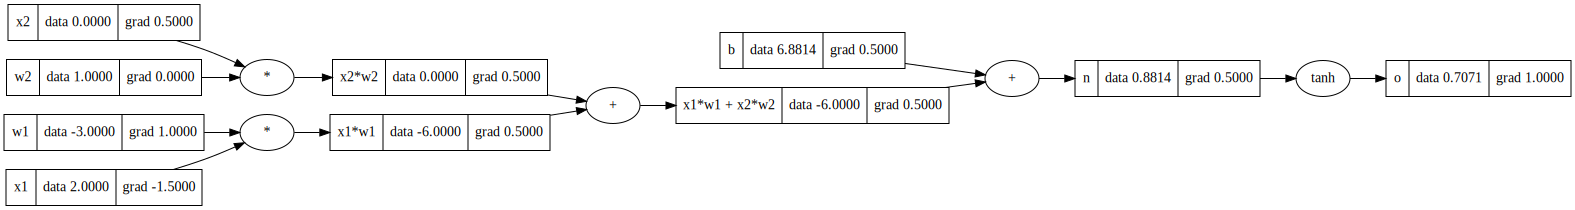

In [42]:
draw_dot(o)

In [43]:
# autmaitc gradient computation
class Value:
    # wraps expression
    # children stores what values created this valye
    # op stores what operations on children exactly created this value
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        # func to calculate gradients
        self._backward = lambda: None # default empty func

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        # allow adding of two Value obj
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        # allow multiplying of two Value obj
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward
        return out

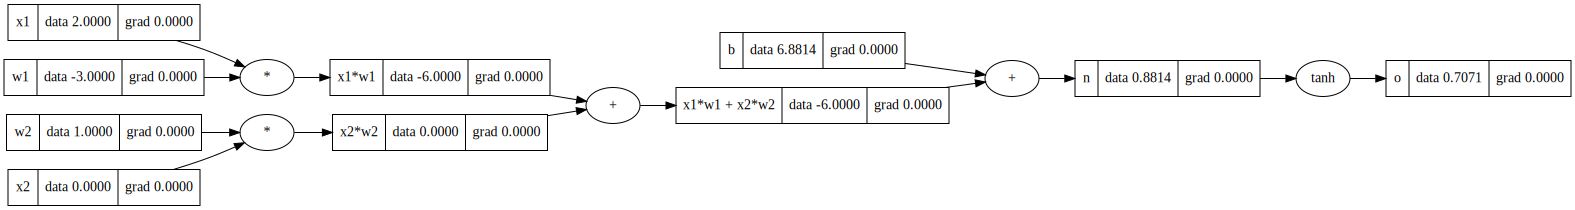

In [44]:
# automatic backprop for neuron
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [45]:
# call backward in right order
# init o.grad = 1
o.grad = 1.0
o._backward()

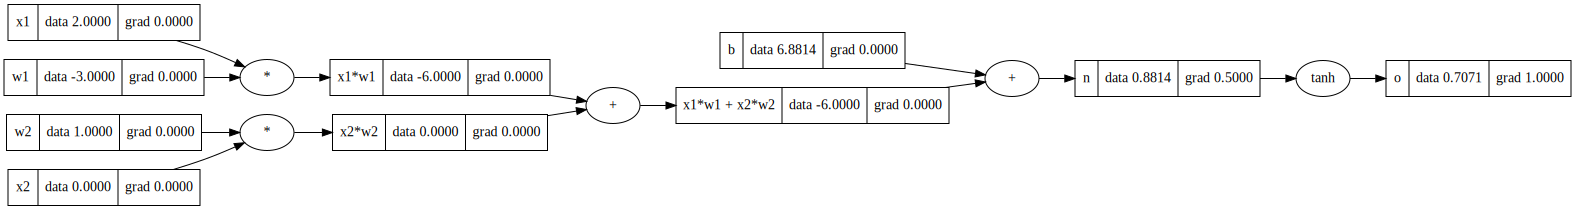

In [46]:
draw_dot(o)

In [47]:
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
w2._backward()
x2._backward()
w1._backward()
x1._backward()

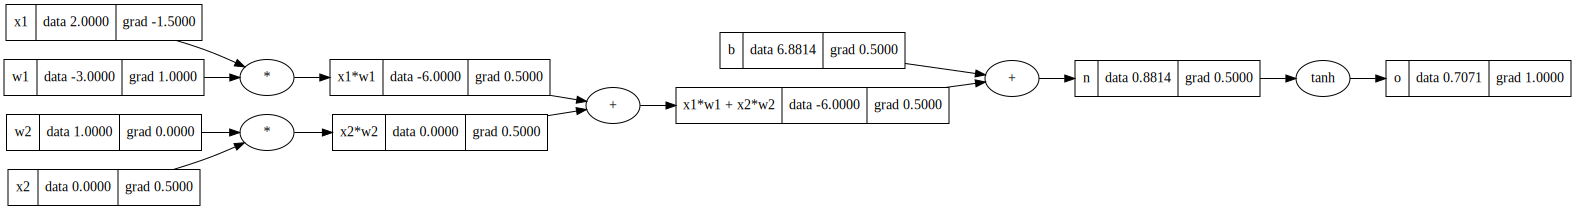

In [48]:
draw_dot(o)

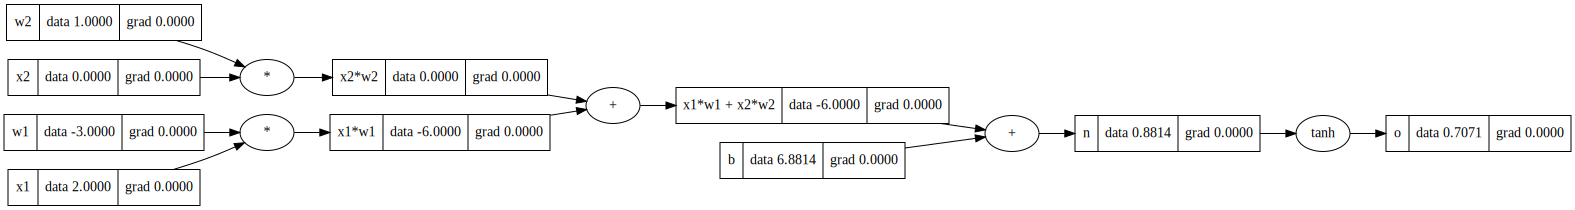

In [49]:
# automatic backprop for neuron with topo sort
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [50]:
# we can do topo sort to call _backward func in correct order
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=(6.881373587019543)),
 Value(data=(-3.0)),
 Value(data=(2.0)),
 Value(data=(-6.0)),
 Value(data=(0.0)),
 Value(data=(1.0)),
 Value(data=(0.0)),
 Value(data=(-6.0)),
 Value(data=(0.8813735870195432)),
 Value(data=(0.7071067811865476))]

In [51]:
o.grad = 1.0
for node in reversed(topo):
    node._backward()

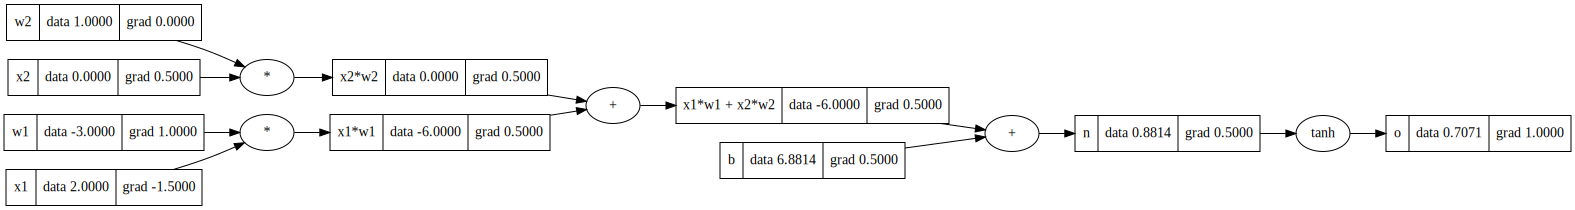

In [52]:
draw_dot(o)

In [53]:
# put this code in Value obj
# autmaitc gradient computation
class Value:
    # wraps expression
    # children stores what values created this valye
    # op stores what operations on children exactly created this value
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        # func to calculate gradients
        self._backward = lambda: None # default empty func

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        # allow adding of two Value obj
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        # allow multiplying of two Value obj
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

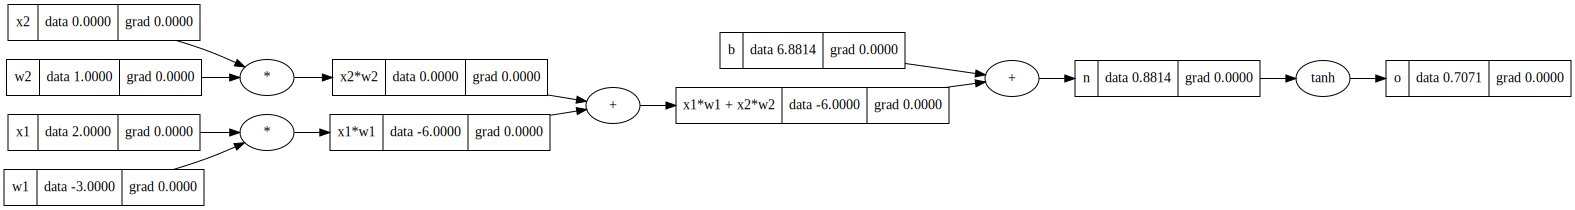

In [54]:
# automatic backprop for neuron with topo sort
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [55]:
o.backward()

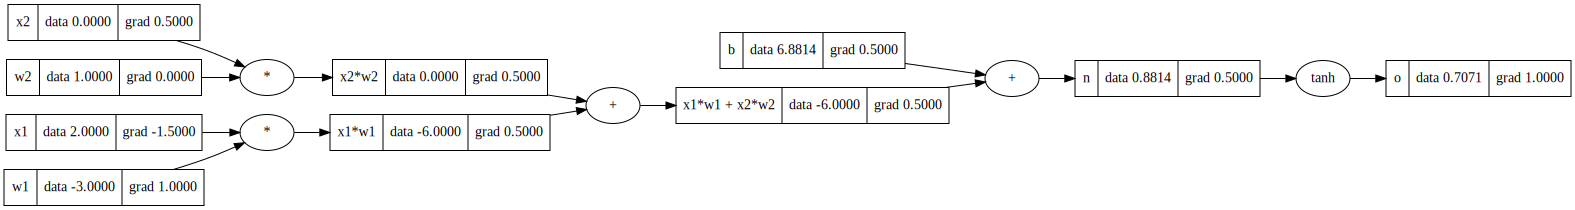

In [56]:
draw_dot(o)

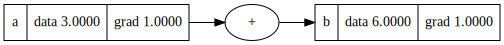

In [57]:
# there is bug in our implementation
# test case
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
# it has two arrows on top of it
draw_dot(b)

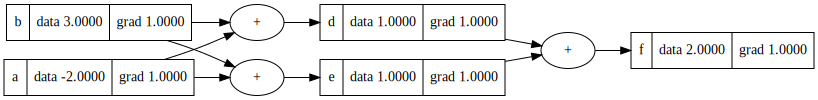

In [58]:
# graident not correct
# it should be db/da = 2.0
# pther way to see it
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a + b; d.label = 'd'
e = a + b; e.label = 'e'
f = d + e; f.label = 'f'

f.backward()

draw_dot(f)
# what is happening is when u use same variable mutliple time
# its grad is updated through different paths in graph
# and it overwrites prev path gradient
# instead it should add to prev gradient


In [59]:
# fix bug
# put this code in Value obj
# autmaitc gradient computation
class Value:
    # wraps expression
    # children stores what values created this valye
    # op stores what operations on children exactly created this value
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        # func to calculate gradients
        self._backward = lambda: None # default empty func

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        # allow adding of two Value obj
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # add instead of overwriting grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        # allow multiplying of two Value obj
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

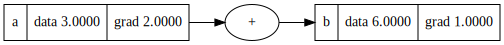

In [60]:
# there is bug in our implementation
# test case
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
# it has two arrows on top of it
draw_dot(b)

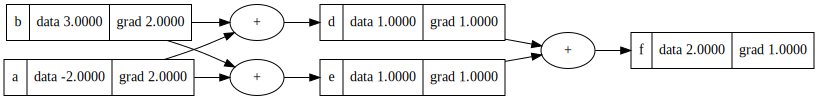

In [61]:
# graident not correct
# it should be db/da = 2.0
# pther way to see it
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a + b; d.label = 'd'
e = a + b; e.label = 'e'
f = d + e; f.label = 'f'

f.backward()

draw_dot(f)
# what is happening is when u use same variable mutliple time
# its grad is updated through different paths in graph
# and it overwrites prev path gradient
# instead it should add to prev gradient


In [62]:
# we cannot do
a = Value(2.0)
# a + 1
# rhis will fail

In [63]:
# fix
# fix bug
# put this code in Value obj
# autmaitc gradient computation
class Value:
    # wraps expression
    # children stores what values created this valye
    # op stores what operations on children exactly created this value
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        # func to calculate gradients
        self._backward = lambda: None # default empty func

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        # allow adding of two Value obj
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # add instead of overwriting grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # allow multiplying of two Value obj
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [64]:
a = Value(2.0)
a + 1

Value(data=(3.0))

In [65]:
a = Value(2.0)
a * 2

Value(data=(4.0))

In [66]:
a = Value(2.0)
# 2 * a
# this wont work cause 2*a != a*2

In [67]:
# fix
# fix bug
# put this code in Value obj
# autmaitc gradient computation
class Value:
    # wraps expression
    # children stores what values created this valye
    # op stores what operations on children exactly created this value
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        # func to calculate gradients
        self._backward = lambda: None # default empty func

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        # allow adding of two Value obj
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # add instead of overwriting grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other): # other * self
        other = other if isinstance(other, Value) else Value(other)
        # allow multiplying of two Value obj
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # handles 2 * self
        # called if __mul__ fails second time
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [68]:
a = Value(2.0)
2 * a

Value(data=(4.0))

In [69]:
# adding more operations
# fix
# fix bug
# put this code in Value obj
# autmaitc gradient computation
class Value:
    # wraps expression
    # children stores what values created this valye
    # op stores what operations on children exactly created this value
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        # func to calculate gradients
        self._backward = lambda: None # default empty func

    def __repr__(self):
        return f"Value(data=({self.data}))"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        # allow adding of two Value obj
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # add instead of overwriting grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other): # other * self
        other = other if isinstance(other, Value) else Value(other)
        # allow multiplying of two Value obj
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # handles 2 * self
        # called if __mul__ fails second time
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad 
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [70]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=(0.5))

In [71]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=(-2.0))

In [72]:
# automatic backprop for neuron with topo sort
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

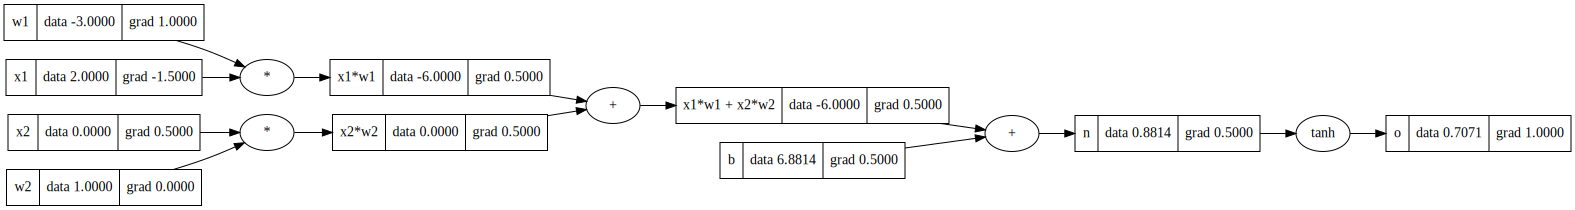

In [73]:
draw_dot(o)

In [74]:
# automatic backprop for neuron with topo sort
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# tanh as e**x formula
o = n.tanh();
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()

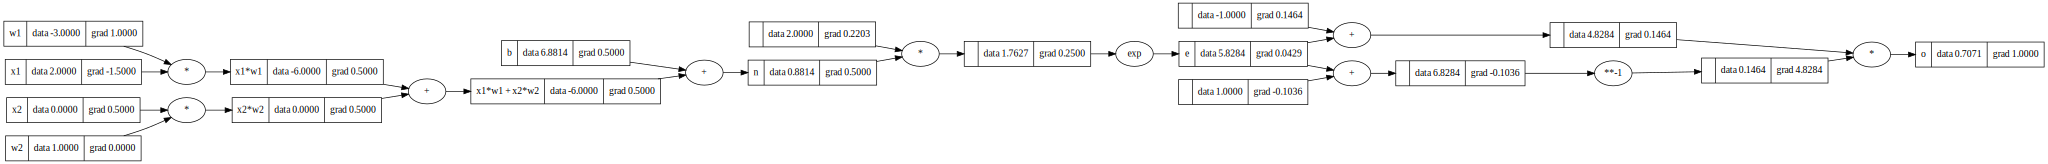

In [75]:
draw_dot(o)

In [76]:
# same thing in pytorch
import torch

# micrograd is scaler thing
# pytorch speeds up thing using tensors
# for parallization
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [77]:
import random

class Neuron:
    # nin is num of input to neuron
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # pairwise multipy eac element of w with each ekement of x
        out = Value(0.0)
        for wi, xi in zip(self.w, x):
            out += wi*xi
        out += self.b
        
        return out.tanh()

    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=(-0.31613625361026415))

In [78]:
class Layer:
    # nin num of input of layer
    # nout is num of neuron in this layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # run input for each neuron in layer
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params

x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=(-0.9884323164181656)),
 Value(data=(0.8452678097131159)),
 Value(data=(-0.4822592668233122))]

In [79]:
# Network
class MLP:
    # nin is num of input of network
    # nouts is list of nouts for each layer
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
o = n(x)

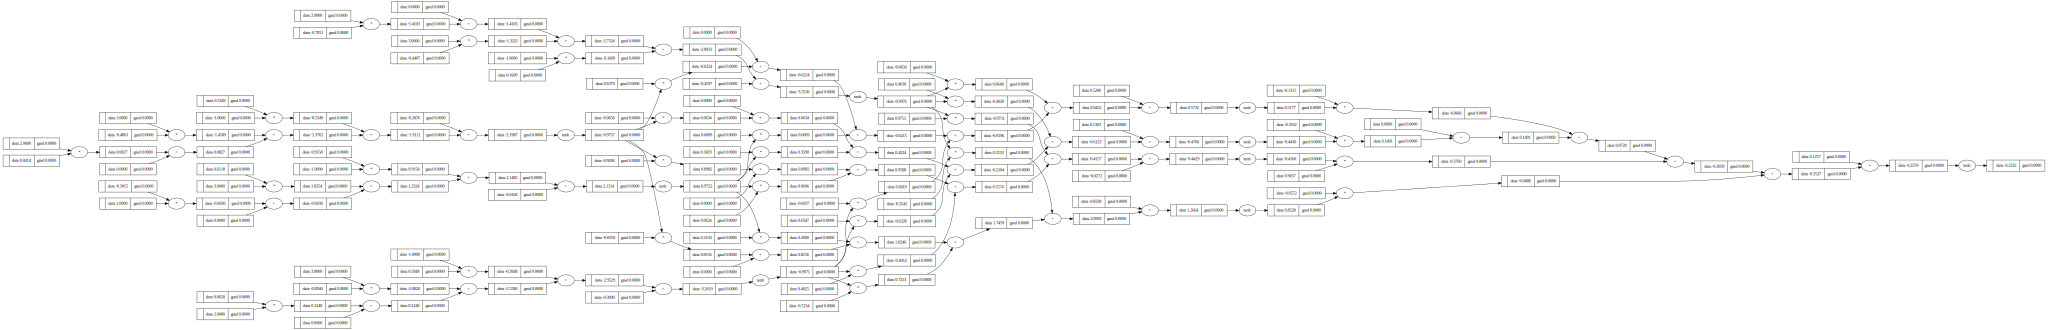

In [80]:
draw_dot(o)

In [81]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
y_pred = [n(x) for x in xs]
y_pred

[Value(data=(-0.223165408712121)),
 Value(data=(-0.5259423914837091)),
 Value(data=(-0.38863418631578256)),
 Value(data=(-0.24936861196669557))]

In [82]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, y_pred)), Value(0.0))

In [83]:
loss

Value(data=(3.6555543199714284))

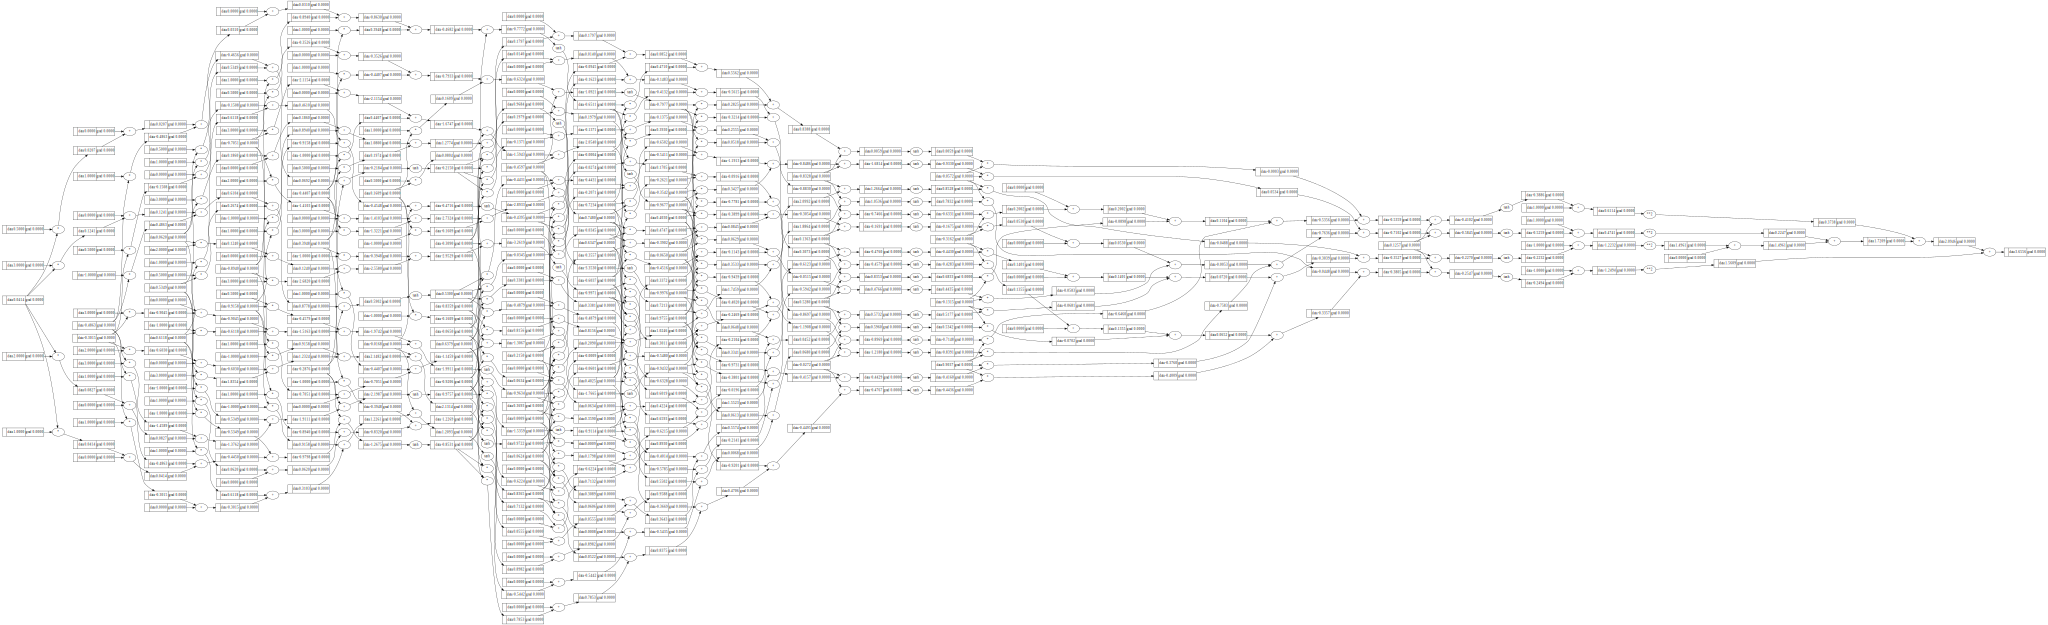

In [84]:
draw_dot(loss)

In [85]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    # gradient point in direction of increasing loss
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 3.6555543199714284
1 2.2253556668871504
2 0.1804004405812199
3 0.09722184114036911
4 0.07545582135072437
5 0.06201658736936898
6 0.05269055560641445
7 0.04579737469160462
8 0.0404833475640342
9 0.03625820345432581
10 0.0328174979511188
11 0.029961297932041546
12 0.02755255723570308
13 0.02549406642270086
14 0.023714905293831474
15 0.022162095407815212
16 0.0207952536207746
17 0.01958305465048962
18 0.018500824672133362
19 0.01752886445184032


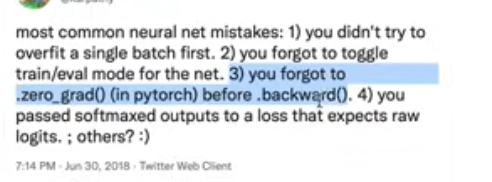